In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

# Configuration
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Load the dataset
url = "https://raw.githubusercontent.com/akay6483/mmml-ecommerce/main/dataset/Wholesale%20customers%20data.csv"
df = pd.read_csv(url)

# Basic Inspection
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (440, 8)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [14]:
# 1. Feature Selection
# Dropping 'Channel' and 'Region' to focus on spending behavior (continuous variables)
features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
X = df[features]

# 2. Scaling
# Standardization is crucial as spending scales vary significantly between categories
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame for scaled data (optional, for reference)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
print("Data scaled and ready for clustering.")

Data scaled and ready for clustering.


In [15]:
# --- 1. K-Means Clustering ---
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# --- 2. Hierarchical Clustering ---
agg_model = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_labels = agg_model.fit_predict(X_scaled)

# --- 3. DBSCAN ---
# Using eps=0.5 and min_samples=5 as a starting point
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

print("All four clustering models have been trained.")

All four clustering models have been trained.


In [16]:
# Helper function to calculate score safely (handles cases with only 1 cluster/noise)
def calculate_silhouette(X, labels):
    unique_labels = np.unique(labels)
    if len(unique_labels) > 1:
        # Filter out noise points (-1) for DBSCAN if desired,
        # but standard practice is to include them or check if only noise exists.
        return silhouette_score(X, labels)
    else:
        return -1  # Invalid score

# Calculate Scores
scores = {
    "K-Means": calculate_silhouette(X_scaled, kmeans_labels),
    "Hierarchical": calculate_silhouette(X_scaled, agg_labels),
    "DBSCAN": calculate_silhouette(X_scaled, dbscan_labels),
}

# Display Results
results_df = pd.DataFrame(list(scores.items()), columns=['Algorithm', 'Silhouette Score'])
display(results_df.sort_values(by='Silhouette Score', ascending=False))

,Algorithm,Silhouette Score
0,K-Means,0.548287
1,Hierarchical,0.264609
2,DBSCAN,0.195811


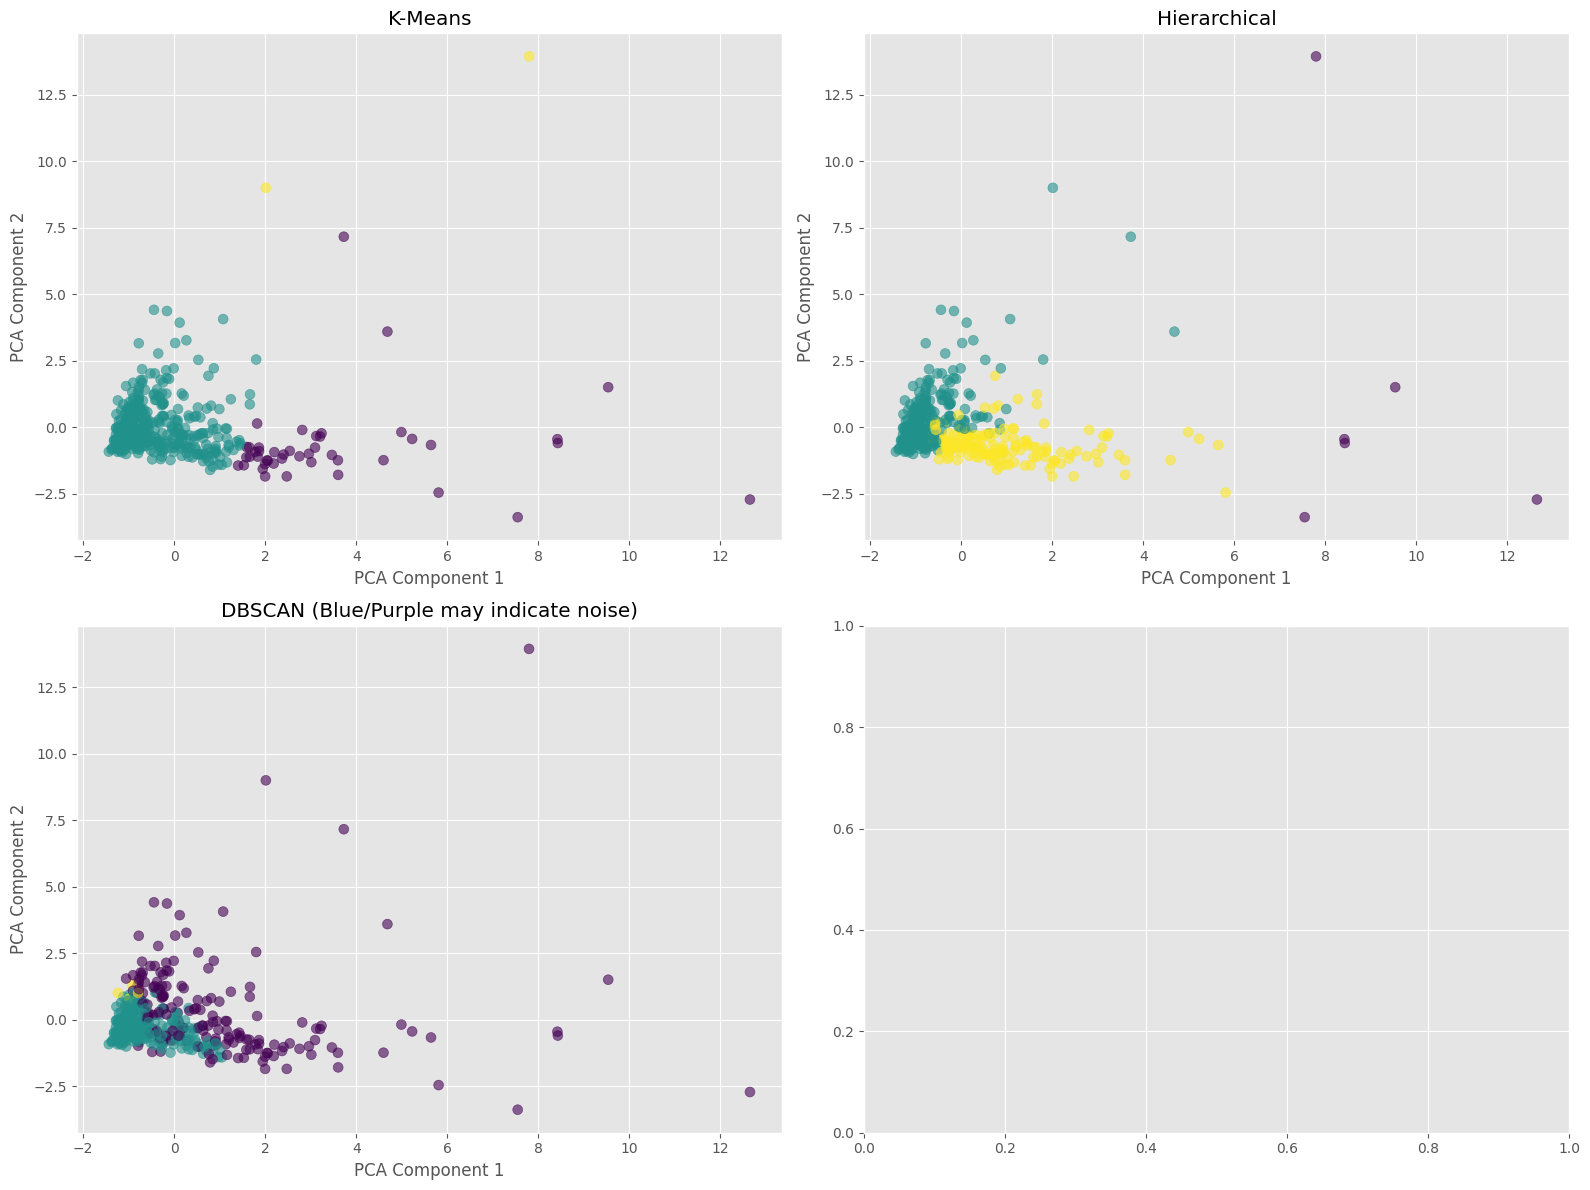

In [17]:
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define plot helper
def plot_cluster(ax, labels, title):
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    # Add legend/colorbar if needed, but distinct colors suffice for structure

# Plot each method
plot_cluster(axes[0, 0], kmeans_labels, "K-Means")
plot_cluster(axes[0, 1], agg_labels, "Hierarchical")
plot_cluster(axes[1, 0], dbscan_labels, "DBSCAN (Blue/Purple may indicate noise)")


plt.tight_layout()
plt.show()

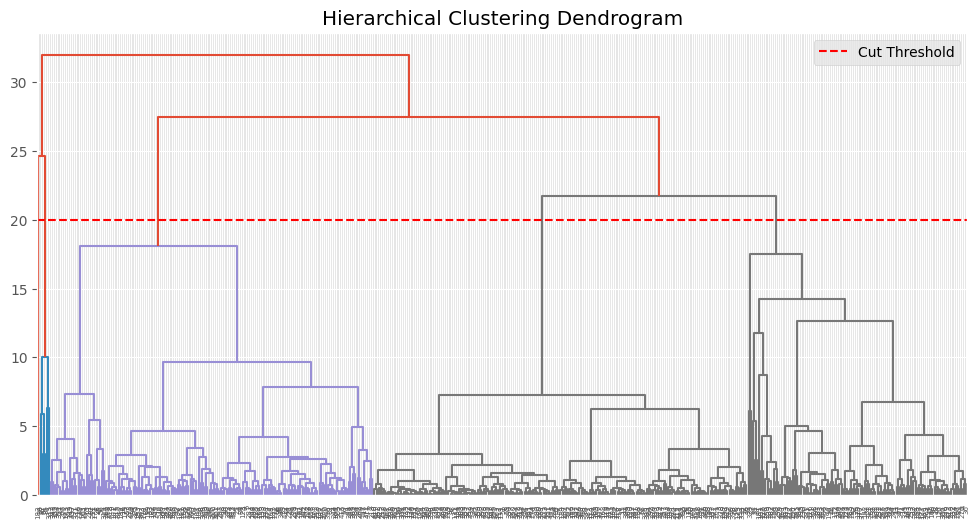

In [18]:
# Visualize the hierarchy
plt.figure(figsize=(12, 6))
plt.title("Hierarchical Clustering Dendrogram")
dend = shc.dendrogram(shc.linkage(X_scaled, method='ward'))
plt.axhline(y=20, color='r', linestyle='--', label='Cut Threshold')
plt.legend()
plt.show()